# Entropy Estimation with RDP

In [1]:
import torch 
import sklearn

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from torch import nn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pandas import DataFrame

from collections import Counter
from tqdm import tqdm 

from transformers import GPT2Tokenizer, GPT2Model
from nltk.corpus import stopwords
from matplotlib.pyplot import figure
from matplotlib import collections as mc
from matplotlib.colors import ListedColormap

In [2]:
import sys 
sys.path.append('..')

In [3]:
from frtorch.structure.linear_chain_crf import LinearChainCRF

In [4]:
%matplotlib inline 
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
crf = LinearChainCRF('minmax', 10)

In [27]:
ckpt_path = '../../local/gpt2net_test/state_matrix_e0_b400.pt'
ckpt = torch.load(ckpt_path)

state_matrix_l = ckpt['state_matrix_norm'] 
transition_l = ckpt['transition']
emission_l = ckpt['emission'] 
x_lens_l = ckpt['x_lens']
x_enc = ckpt['x_enc']
x_emb = ckpt['x_emb']

with torch.no_grad():
    ent = crf.entropy(transition_l, emission_l, x_lens_l)

In [28]:
ent

tensor([34.6691], device='cuda:0')

In [50]:
ckpt_path = '../../local/gpt2net_test/state_matrix_e0_b380.pt'
ckpt = torch.load(ckpt_path)

state_matrix_m = ckpt['state_matrix_norm'] 
transition_m = ckpt['transition']
emission_m = ckpt['emission'] 
x_lens_m = ckpt['x_lens']

with torch.no_grad():
    ent = crf.entropy(transition_m, emission_m, x_lens_m)
    
print(ent)

tensor([18.0883], device='cuda:0')


In [51]:
ckpt_path = '../../local/gpt2net_test/state_matrix_e0_b350.pt'
ckpt = torch.load(ckpt_path)

state_matrix_s = ckpt['state_matrix_norm'] 
transition_s = ckpt['transition']
emission_s = ckpt['emission'] 
x_lens_s = ckpt['x_lens']

with torch.no_grad():
    ent = crf.entropy(transition_s, emission_s, x_lens_s)
    
print(ent)

tensor([6.4690], device='cuda:0')


In [18]:
_, log_z_exact = crf.forward_sum(transition_l, emission_l, x_lens_l)
print(log_z_exact)

tensor([91.9613], device='cuda:0')


In [19]:
est = crf.forward_approx(state_matrix_l, emission_l, x_lens_l, sum_size=18, proposal='softmax', transition_proposal='l1norm', sample_size=2)
print(est)

tensor([92.0529], device='cuda:0', grad_fn=<LogsumexpBackward>)


In [17]:
x_lens_l

tensor([11], device='cuda:0')

In [34]:
ent_approx = crf.entropy_approx(state_matrix_l, emission_l, x_lens_l, sum_size=100, proposal='softmax', transition_proposal='l1norm', sample_size=100, topk_sum=False)

In [35]:
ent_approx

tensor([34.8244], device='cuda:0', grad_fn=<SumBackward1>)

In [36]:
N = 100
with torch.no_grad():
    estimates_0 = []
    estimates_1 = []
    for _ in tqdm(range(100)):
        ent_est = crf.entropy_approx(state_matrix_l, emission_l, x_lens_l, sum_size=100, proposal='softmax', transition_proposal='l1norm', sample_size=100, topk_sum=False)
        estimates_0.append(ent_est[0].item())
        
        ent_est = crf.entropy_approx(state_matrix_l, emission_l, x_lens_l, sum_size=10, proposal='softmax', transition_proposal='l1norm', sample_size=10, topk_sum=False)
        estimates_1.append(ent_est[0].item())

100%|██████████| 100/100 [00:02<00:00, 46.97it/s]


In [ ]:
estimates = pd.DataFrame(
                {
                 'estimates': np.array(
                     estimates_0 + estimates_1
                 ), 
                 'memory': np.array(
                                      ['10%'] * N + 
                                      ['1%'] * N
                                     )
                }
            )

plt.figure(figsize=(4,2))
ax = sns.kdeplot(data=estimates, x="estimates", hue='memory', fill=True, alpha=.2)
ax.set(ylabel=None)
plt.axvline(x=ent.cpu().item(), color='#CC2F27')
plt.show()

## Compare memory consumption

In [46]:
def compare_topk(state_matrix, transition, emission, x_lens, N, yloc=0.1, offset=0.1, xlim=None):
    with torch.no_grad():
        ent_exact = crf.entropy(transition, emission, x_lens)
        ent_exact = ent_exact[0].cpu().item()
        
        ent_ksum_25 = crf.entropy_approx(state_matrix, emission, x_lens, sum_size=500, proposal='softmax', transition_proposal='l1norm', sample_size=2, topk_sum=True).cpu().item()
        ent_ksum_50 = crf.entropy_approx(state_matrix, emission, x_lens, sum_size=1000, proposal='softmax', transition_proposal='l1norm', sample_size=2, topk_sum=True).cpu().item()

        ent_est_20 = []
        ent_est_200 = []
        ent_est_400 = []
        ent_est_1000 = []
        for _ in tqdm(range(N)):
            est = crf.entropy_approx(state_matrix, emission, x_lens, sum_size=18, proposal='softmax', transition_proposal='l1norm', sample_size=2, topk_sum=False)
            ent_est_20.append(est[0].cpu().item())

            est = crf.entropy_approx(state_matrix, emission, x_lens, sum_size=198, proposal='softmax', transition_proposal='l1norm', sample_size=2, topk_sum=False)
            ent_est_200.append(est[0].cpu().item())

            est = crf.entropy_approx(state_matrix, emission, x_lens, sum_size=398, proposal='softmax', transition_proposal='l1norm', sample_size=2, topk_sum=False)
            ent_est_400.append(est[0].cpu().item())
            
            est = crf.entropy_approx(state_matrix, emission, x_lens, sum_size=998, proposal='softmax', transition_proposal='l1norm', sample_size=2, topk_sum=False)
            ent_est_1000.append(est[0].cpu().item())

        estimates = pd.DataFrame(
            {
             'estimates': np.array(
                 ent_est_20 + ent_est_200 + ent_est_400 + ent_est_1000
             ), 
             'memory': np.array(
                                  ['1%'] * N
                                  + ['10%'] * N
                                  + ['20%'] * N
                                  + ['50%'] * N
                                 )}
            )

        plt.figure(figsize=(4,2))
        ax = sns.kdeplot(data=estimates, x="estimates", hue='memory', fill=True, alpha=.2)
        ax.set(ylabel=None)
        plt.axvline(x=ent_exact, color='#CC2F27')
        
        plt.axvline(x=ent_ksum_25, color='gray')
        plt.axvline(x=ent_ksum_50, color='gray')
        plt.text(ent_ksum_25+offset, yloc, 'TopK Sum\n25% Mem', size=9)
        plt.text(ent_ksum_50+offset, yloc, 'TopK Sum\n50% Mem', size=9)
        
        plt.tick_params(axis='both', which='both', left=False, bottom=True, right=False, top=False, labelleft=False, labelbottom=True) 
        # move_legend(ax, 'upper left')
        plt.xlim(xlim)
        
        print('bias:')
        print(ent_ksum_25 - ent_exact, 
              ent_ksum_50 - ent_exact, 
              np.mean(ent_est_20) - ent_exact, 
              np.mean(ent_est_200) - ent_exact, 
              np.mean(ent_est_400) - ent_exact,
              np.mean(ent_est_1000) - ent_exact
             )
        print('variance:')
        print(np.var(ent_est_20), np.var(ent_est_200), np.var(ent_est_400), np.var(ent_est_1000))
        print('mse')
        print((ent_ksum_25 - ent_exact)**2, 
              (ent_ksum_50 - ent_exact)**2, 
              np.mean((np.array(ent_est_20) - ent_exact)**2), 
              np.mean((np.array(ent_est_200) - ent_exact)**2), 
              np.mean((np.array(ent_est_400) - ent_exact)**2),
              np.mean((np.array(ent_est_1000) - ent_exact)**2)
             )
    return 

# Dense Case

100%|██████████| 100/100 [00:07<00:00, 13.29it/s]


bias:
-21.065144538879395 -11.480998992919922 -0.7065925598144531 -0.005335006713863777 0.012423400878908808 -0.05595363616943416
variance:
5.426422042145423 2.1157734982410825 1.3265687576678697 0.2986529116239675
mse
443.7403144438804 131.81333787542826 5.925695087730564 2.1158019605377194 1.3267230985572678 0.30178372102454887


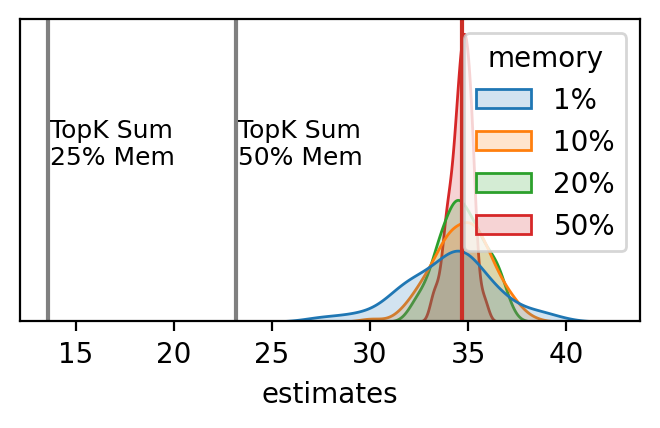

In [47]:
N = 100
compare_topk(state_matrix_l, transition_l, emission_l, x_lens_l, N, yloc=0.1, offset=0.1, xlim=None)

# Intermediate

100%|██████████| 100/100 [00:07<00:00, 13.31it/s]


bias:
-9.184341430664062 -4.70107364654541 -0.2350449752807613 -0.12332745552063074 -0.19434562683105483 0.051870422363279545
variance:
1.9342755750164995 1.2837538173006633 0.6927586991519405 0.14344928690137165
mse
84.3521275150124 22.10009343024376 1.9895217154212332 1.2989634785858561 0.730528921820296 0.14613982761751687


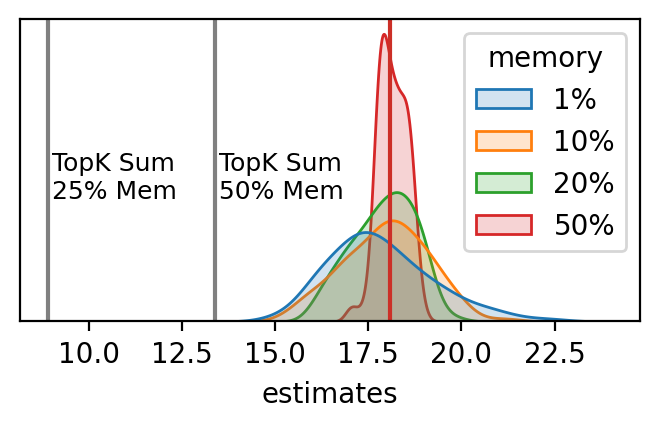

In [55]:
N = 100
compare_topk(state_matrix_m, transition_m, emission_m, x_lens_m, N, yloc=0.1, offset=0.1, xlim=None)

# Long Tail

100%|██████████| 100/100 [00:07<00:00, 13.43it/s]


bias:
-2.8304667472839355 -1.3459672927856445 -0.03869260072708158 0.01075178623199502 0.02418290138244661 0.0023764991760257814
variance:
0.6899725400168251 0.3166365982136161 0.20652132213763974 0.06312256198580726
mse
8.011542007480102 1.811627953248717 0.6914696573678504 0.31675219912079455 0.20710613485691284 0.0631282097341409


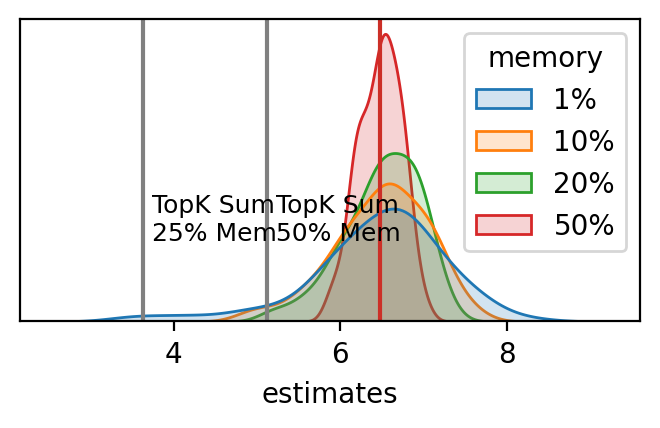

In [56]:
N = 100
compare_topk(state_matrix_s, transition_s, emission_s, x_lens_s, N, yloc=0.1, offset=0.1, xlim=None)